In [1]:
import os
os.chdir('/home/icb/lisa.sikkema/software/feature-attribution-sc/')

In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import sys
sys.path.append("./scripts/")
import benchmarking

In [9]:
ranking_dfs = dict()

In [10]:
ranking_dfs['ablation'] = pd.read_csv("./outputs/ablation/task2.csv",index_col=0)
ranking_dfs['de'] = pd.read_csv("./outputs/differential_expression/hlca_DE_cell_types.csv",index_col=0)
ranking_dfs['eg_abssum']= pd.read_csv("./outputs/expected_gradients/task_2_absolute_sum_expected_grads.csv",index_col=0)
ranking_dfs['eg_sum']= pd.read_csv("./outputs/expected_gradients/task_2_sum_expected_grads.csv",index_col=0)
ranking_dfs['ig_abssum']= pd.read_csv("./outputs/integrated_gradients/task_2_absolute_sum_integrated_grads.csv",index_col=0)
ranking_dfs['ig_sum']= pd.read_csv("./outputs/integrated_gradients/task_2_sum_integrated_grads.csv",index_col=0)
ranking_dfs['lime_abs']= pd.read_csv("./outputs/lime/lime_absolute.csv",index_col=0)
ranking_dfs['lime_abs']= pd.read_csv("./outputs/lime/lime.csv",index_col=0)
ranking_dfs['random_mean']= pd.read_csv("./outputs/random/task2_mean.csv",index_col=0)
ranking_dfs['random_random']= pd.read_csv("./outputs/random/task2_random.csv",index_col=0)

In [83]:
auc_scores = dict()

In [84]:
for explainer, df in ranking_dfs.items():
    print(explainer)
    auc_scores[explainer] = benchmarking.roc_auc_hlca(df)

de
eg_abssum
eg_sum
ig_abssum
ig_sum
lime_abs
random_mean
random_random
ablation


In [85]:
auc_scores

{'de': 0.05197453532742175,
 'eg_abssum': 0.7537592802451453,
 'eg_sum': 0.2550083306287335,
 'ig_abssum': 0.7505376175981571,
 'ig_sum': 0.6530768104962922,
 'lime_abs': 0.5393283460974455,
 'random_mean': 0.9418018954812549,
 'random_random': 0.9702595929247118,
 'ablation': 0.5902947380809571}

In [11]:
ranking = ranking_dfs['ablation']

In [12]:
marker_dict = benchmarking.hlca_markers()
y_true = ranking[list(set(ranking.columns) & set(marker_dict.keys()))].copy()
y_true[:] = 0
for ct, genes in marker_dict.items():

    if ct in y_true.columns:
        y_true.loc[genes, ct] = 1

In [15]:
import sklearn.metrics as metrics

In [28]:
y_test = y_true.values
y_score = ranking[y_true.columns].values

In [25]:
from sklearn.metrics import roc_curve, auc

In [30]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [31]:
roc_auc['micro']

0.6337289860171139

In [33]:
import matplotlib.pyplot as plt

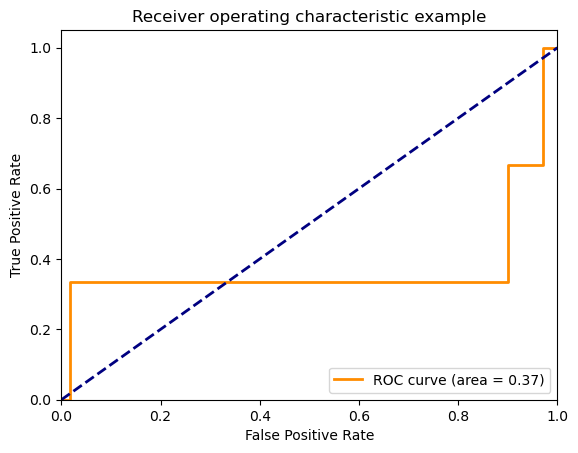

In [35]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()